# Explratory Data Analysis 

In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import r_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [2]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

### Load the data 

In [3]:
def load_data(path):
        if not os.path.isfile(path):
            raise FileNotFoundError(f"The file at {path} was not found.")
        return pd.read_csv(path)

path_to_data="/home/user_stel/Assignment-2/data/breast_cancer.csv"
data_df=load_data(path_to_data)

#print(data_df.head()) #it should display a 512x32 dataframe

In [4]:
print(data_df.head()) #it should display a 512x32 dataframe

   id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0   1         M        14.68         20.13           94.74      684.5   
1   2         B        11.50         18.45           73.28      407.4   
2   3         M        15.85         23.95          103.70      782.7   
3   4         M        18.82         21.97          123.70     1110.0   
4   5         B        12.95         16.02           83.14      513.7   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.09867           0.07200         0.07395              0.05259   
1          0.09345           0.05991         0.02638              0.02069   
2          0.08401           0.10020         0.09938              0.05364   
3          0.10180           0.13890         0.15940              0.08744   
4          0.10050           0.07943         0.06155              0.03370   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         19.07          

### Dataset Overview and Descriptive Statistics

In [5]:
# Examine shape and format of the dataset
print("Dataset Shape:", data_df.shape)

# Examine column data types 
print("\nFeature Column Data Types:\n", data_df.dtypes)

# Examine if there are any duplicate rows
print("\nNumber of duplicate rows:", data_df.duplicated().sum())

Dataset Shape: (512, 32)

Feature Column Data Types:
 id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
c

In [6]:
def preprocess_data(df, columns_to_drop=[]):
    df=df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    num_list=df.select_dtypes(include=[np.number]).columns.tolist()
    cat_list=df.select_dtypes(exclude=[np.number]).columns.tolist()

    for col in cat_list:
        df[col]=LabelEncoder().fit_transform(df[col])

    for col in num_list:
        df[col]=SimpleImputer(missing_values=np.nan, strategy='mean') \
            .fit_transform(df[[col]]).ravel()
    
    return df

data_new_df=preprocess_data(data_df, columns_to_drop=[])
print(data_new_df.head())

    id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0  1.0          1        14.68         20.13           94.74      684.5   
1  2.0          0        11.50         18.45           73.28      407.4   
2  3.0          1        15.85         23.95          103.70      782.7   
3  4.0          1        18.82         21.97          123.70     1110.0   
4  5.0          0        12.95         16.02           83.14      513.7   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.09867           0.07200         0.07395              0.05259   
1          0.09345           0.05991         0.02638              0.02069   
2          0.08401           0.10020         0.09938              0.05364   
3          0.10180           0.13890         0.15940              0.08744   
4          0.10050           0.07943         0.06155              0.03370   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         19.

Absolute Class Frequencies:
diagnosis
0    321
1    191
Name: count, dtype: int64

Class Proportions:
diagnosis
0    0.626953
1    0.373047
Name: proportion, dtype: float64


/tmp/ipykernel_55812/1493457592.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=data_new_df, order=desired_order, palette='Dark2')


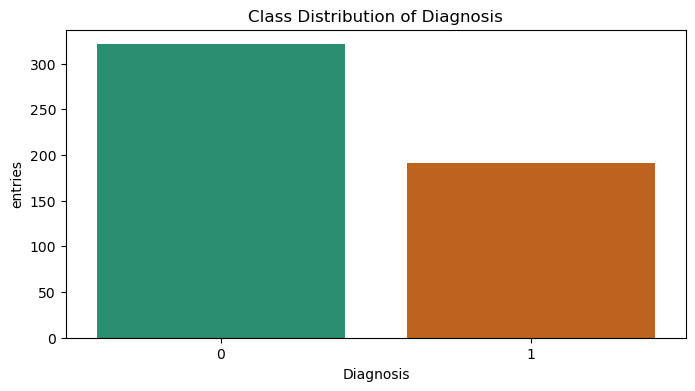

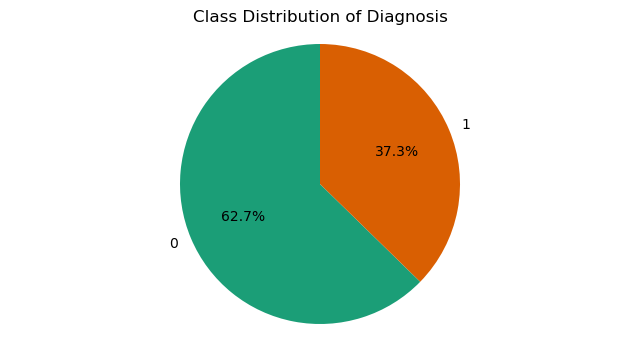

In [15]:
# Examine class imbalance
# M=1, B=0
desired_order = [0, 1]  

diagnosis_entries = data_new_df['diagnosis'].value_counts().reindex(desired_order)
print("Absolute Class Frequencies:")
print(diagnosis_entries)

diagnosis_proportions = data_new_df['diagnosis'].value_counts(normalize=True)
print("\nClass Proportions:")
print(diagnosis_proportions)

# Visualization: Box-Plot
plt.figure(figsize=(8, 4))
sns.countplot(x='diagnosis', data=data_new_df, order=desired_order, palette='Dark2')
plt.title("Class Distribution of Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("entries")
plt.show()

# Visualization: Pie Chart
plt.figure(figsize=(8, 4))
plt.pie(
    diagnosis_entries,
    labels=diagnosis_entries.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Dark2')
)
plt.title("Class Distribution of Diagnosis")
plt.axis('equal') 
plt.show()

### Feature Assessment and Visualization

In [8]:
def separate_features_target(df, target, columns_to_remove=None):
    if columns_to_remove is None:
        columns_to_remove=[]
    columns_to_remove=set(columns_to_remove + [target])
    X=df.drop(columns=[col for col in columns_to_remove if col in df.columns])
    y=df[target]
    return X, y

X, y=separate_features_target(data_new_df, target='diagnosis', columns_to_remove=None)
#print(X)
#print(y)

### Not sure if needed supervised correlation analysis between features and target ???

The selected features of 30 were: 15
['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


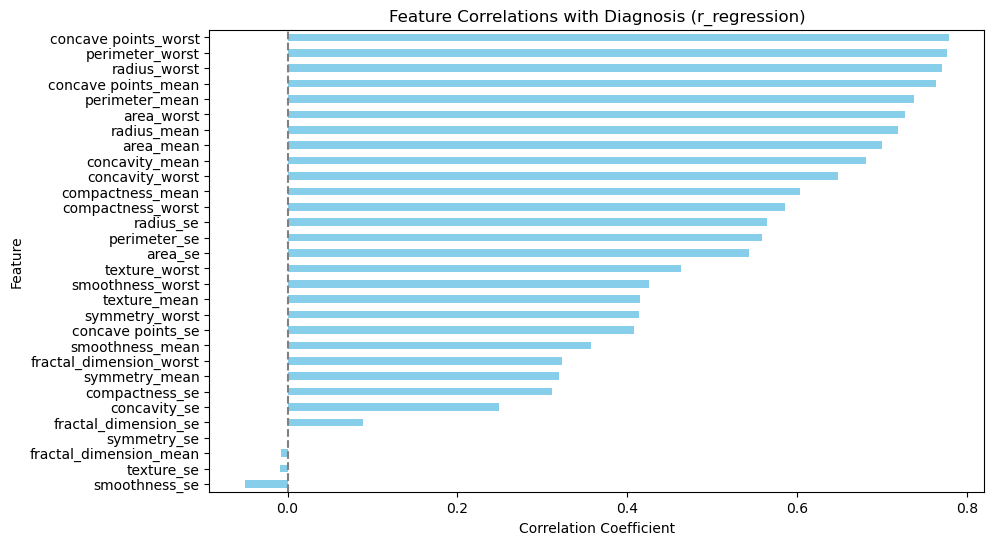

In [ ]:
def select_features(X, y, threshold=0.1):
    correlations = pd.Series(r_regression(X, y), index=X.columns)
    selected_features = correlations[correlations.abs() >= threshold].index.tolist()
    print(f"The selected features of {X.shape[1]} were: {len(selected_features)}")
    return selected_features, correlations

selected_features, correlations=select_features(X, y, threshold=0.5)
print(selected_features)

plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title("Feature Correlations with Diagnosis")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.axvline(0, color='grey', linestyle='--')
plt.show()

### Boxplots of Feature Distributions

In [ ]:
# Identify numeric features (exclude the target column if needed)
features = data_new_df.drop(columns=['diagnosis', 'id']).columns.tolist()

# Define the layout for plots: here we create a grid based on the number of features.
n_features = len(features)
n_cols = 4  # number of columns per row in the subplot grid (adjust based on preference)
n_rows = (n_features // n_cols) + int(n_features % n_cols != 0)

plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=data_new_df[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.tight_layout()
plt.suptitle("Box Plots of Feature Distributions", fontsize=14, y=1.02)
plt.show()


### Correlation Analysis between features

Highly correlated pairs:
radius_mean          perimeter_mean          0.990177
radius_worst         perimeter_worst         0.989319
perimeter_mean       area_mean               0.982107
radius_mean          area_mean               0.980714
radius_worst         area_worst              0.979668
perimeter_worst      area_worst              0.971410
radius_se            perimeter_se            0.968714
perimeter_mean       radius_worst            0.965385
                     perimeter_worst         0.964590
radius_mean          radius_worst            0.961739
area_mean            radius_worst            0.958154
radius_mean          perimeter_worst         0.955707
area_mean            area_worst              0.954514
                     perimeter_worst         0.953261
radius_se            area_se                 0.948526
perimeter_se         area_se                 0.936659
perimeter_mean       area_worst              0.936443
radius_mean          area_worst              0.933432
tex

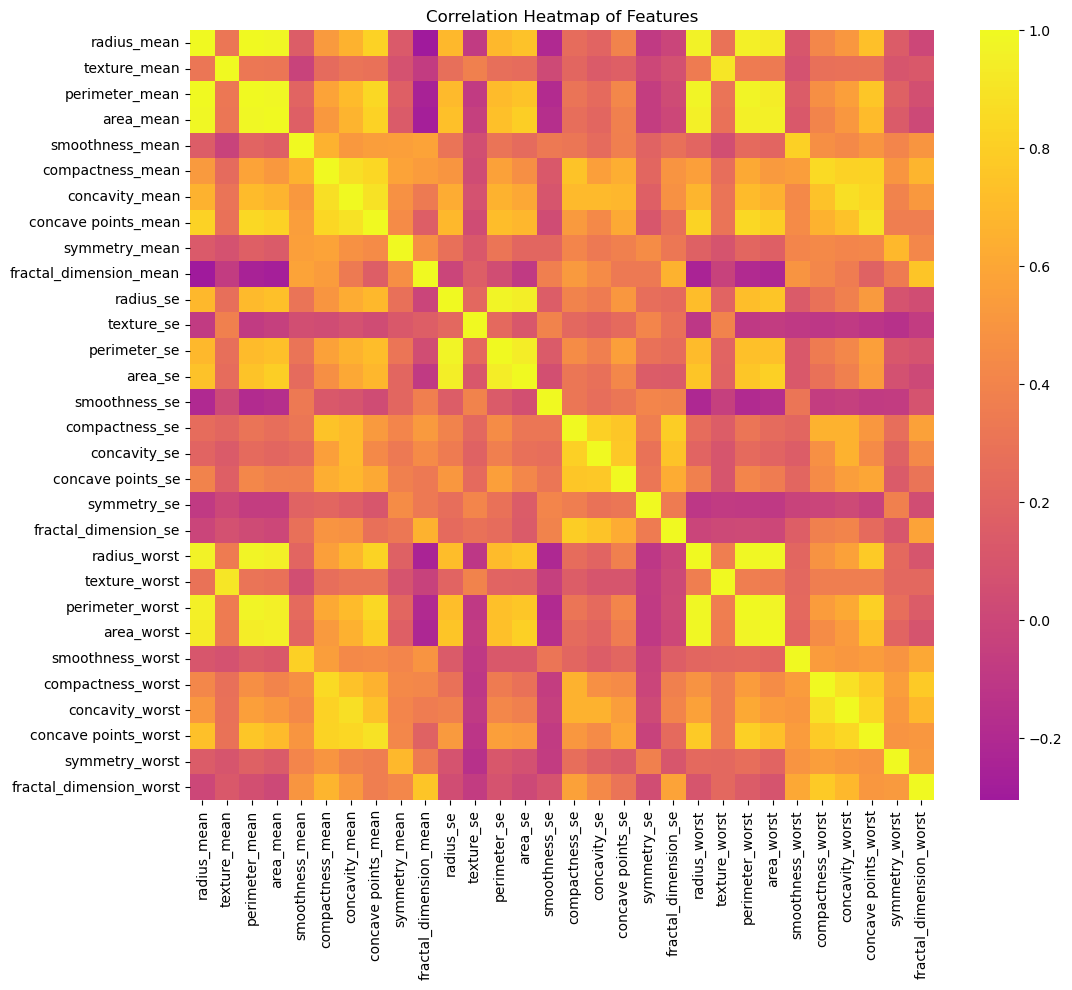

In [22]:
features = data_new_df.drop(columns=['diagnosis', 'id']).columns.tolist()
correlation_matrix=data_new_df[features].corr(method='pearson')

threshold = 0.8
high_corr_pairs = (
    correlation_matrix.abs()
    .where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]

print("Highly correlated pairs:")
print(high_corr_pairs)

# Species to remove (second species in each pair)
features_to_remove = set()

for pair in high_corr_pairs.index:
    features_to_remove.add(pair[1])

print("Species to remove:", features_to_remove)

# Drop highly correlated features
data_selected_df = data_new_df.drop(columns=features_to_remove)
print(f"Reduced from {len(data_new_df.columns)} to {len(data_selected_df.columns)} columns.")

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='plasma', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()

### PCA

[0.98009107 0.01800814]


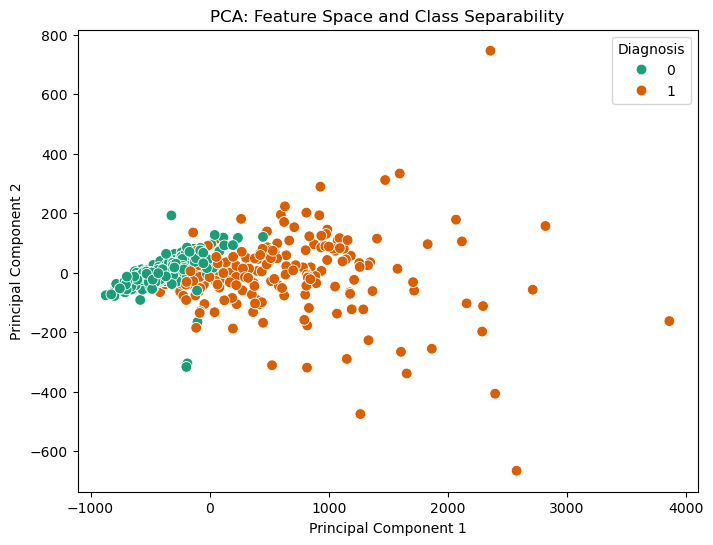

In [36]:
X, y=separate_features_target(data_new_df, target='diagnosis', columns_to_remove=['id'])
pca = PCA(n_components=2, svd_solver='covariance_eigh')
X_reduced=pca.fit_transform(X)
print(pca.explained_variance_ratio_)

pca_df = pd.DataFrame(data=X_reduced, columns=['PC1', 'PC2'])
pca_df['diagnosis'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='diagnosis', data=pca_df, palette='Dark2', s=60)
plt.title("PCA: Feature Space and Class Separability")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Diagnosis")
plt.show()

